In [1]:
SEED = 123

import numpy as np
np.random.seed(SEED)

import pandas as pd
pd.options.display.max_rows = 10

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample

import matplotlib.pyplot as plt

%config InlineBackend.figure_format = "retina"

In [2]:
!ls -lh data/output/

total 224M
-rw-rw-r-- 1 data-scientist data-scientist 224M Dec 25 20:51 aggregated_historical_transactions.csv


In [3]:
agg_transactions_dtype = dict(top_1_category_1="category",
                              top_1_category_2="category",
                              top_1_category_3="category")

agg_historical_transactions_df = pd.read_csv("data/output/aggregated_historical_transactions.csv",
                                             dtype=agg_transactions_dtype)

assert agg_historical_transactions_df.isnull().any().any() == False

agg_historical_transactions_df

,card_id,pct_of_authorized_transactions,pct_of_category_1_1,top_1_category_1,pct_of_category_2_missing,pct_of_category_2_1,pct_of_category_2_2,pct_of_category_2_3,pct_of_category_2_4,pct_of_category_2_5,...,pct_of_installments_999,top_1_installments,top_1_city_id,min_purchase_amount,avg_purchase_amount,max_purchase_amount,sum_purchase_amount,top_1_purchase_amount,top_1_state_id,top_1_subsector_id
0,C_ID_00007093c1,0.765101,0.187919,0,0.187919,0.000000,0.000000,0.805369,0.000000,0.006711,...,0.0,1,244,-0.728876,-0.515739,1.507069,-76.845041,-0.721363,2,19
1,C_ID_0001238066,0.975610,0.016260,0,0.065041,0.772358,0.000000,0.000000,0.000000,0.162602,...,0.0,1,314,-0.734887,-0.589002,0.768095,-72.447201,-0.596643,9,19
2,C_ID_0001506ef0,0.939394,0.000000,0,0.000000,0.030303,0.000000,0.969697,0.000000,0.000000,...,0.0,0,137,-0.740491,-0.524271,1.493545,-34.601879,-0.724368,19,33
3,C_ID_0001793786,0.875000,0.009259,0,0.527778,0.050926,0.351852,0.069444,0.000000,0.000000,...,0.0,0,179,-0.745405,-0.170306,4.554145,-36.786013,-0.566620,-1,37
4,C_ID_000183fdda,0.951389,0.027778,0,0.027778,0.048611,0.006944,0.909722,0.000000,0.006944,...,0.0,1,161,-0.737892,-0.478041,2.764788,-68.837938,-0.671775,3,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325535,C_ID_ffff1d9928,0.750000,0.166667,0,0.166667,0.083333,0.000000,0.000000,0.750000,0.000000,...,0.0,1,114,-0.746893,-0.623139,0.004418,-7.477673,-0.742415,4,33
325536,C_ID_ffff579d3a,0.868421,0.000000,0,0.000000,0.991228,0.000000,0.000000,0.000000,0.008772,...,0.0,0,70,-0.739244,-0.704323,-0.491457,-80.292768,-0.716855,9,37
325537,C_ID_ffff756266,0.583333,0.125000,0,0.125000,0.875000,0.000000,0.000000,0.000000,0.000000,...,0.0,1,233,-0.746156,-0.229434,1.206403,-5.506420,-0.596643,9,20
325538,C_ID_ffff828181,0.873684,0.057895,0,0.057895,0.094737,0.805263,0.000000,0.036842,0.005263,...,0.0,1,96,-0.745405,-0.632101,0.109528,-120.099200,-0.671775,24,19


In [22]:
data_dtype = dict(feature_1="category",
                  feature_2="category",
                  feature_3="category")

train_df = pd.read_csv("data/input/train.csv", dtype=data_dtype, parse_dates=["first_active_month"])
test_df  = pd.read_csv("data/input/test.csv",  dtype=data_dtype, parse_dates=["first_active_month"])

train_test_first_active_month = pd.concat([train_df.first_active_month, test_df.first_active_month])
test_df.first_active_month.fillna(train_test_first_active_month.value_counts().index[0], inplace=True)

train_df = train_df.merge(agg_historical_transactions_df, how="left", on="card_id")
test_df  = test_df.merge(agg_historical_transactions_df, how="left", on="card_id")

assert train_df.isnull().any().any() == False
assert  test_df.isnull().any().any() == False

display(train_df, test_df)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,pct_of_authorized_transactions,pct_of_category_1_1,top_1_category_1,pct_of_category_2_missing,...,pct_of_installments_999,top_1_installments,top_1_city_id,min_purchase_amount,avg_purchase_amount,max_purchase_amount,sum_purchase_amount,top_1_purchase_amount,top_1_state_id,top_1_subsector_id
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,0.950000,0.000000,0,0.000000,...,0.0,0,69,-0.739395,-0.638341,2.258395,-165.968739,-0.724368,9,34
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,0.968571,0.088571,0,0.088571,...,0.0,1,69,-0.742400,-0.600018,4.630299,-210.006336,-0.733384,9,34
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,0.953488,0.000000,0,0.000000,...,0.0,0,143,-0.730138,-0.678311,-0.145847,-29.167391,-0.701453,5,33
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,1.000000,0.155844,0,0.155844,...,0.0,1,17,-0.740897,-0.642745,1.445596,-49.491364,-0.737892,22,37
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,0.962406,0.112782,0,0.112782,...,0.0,1,17,-0.746156,-0.366073,7.193041,-48.687656,-0.507986,22,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201912,2017-09-01,C_ID_963962de2c,3,2,1,-2.740821,0.913043,0.000000,0,0.000000,...,0.0,0,135,-0.742400,-0.709244,-0.571909,-32.625247,-0.679288,7,33
201913,2015-10-01,C_ID_1314773c0b,3,1,1,0.312917,0.851064,0.000000,0,0.000000,...,0.0,0,90,-0.743918,-0.711339,-0.574253,-33.432922,-0.739395,15,37
201914,2017-08-01,C_ID_7666735b3d,4,3,0,0.093494,0.931034,0.091954,0,0.183908,...,0.0,1,251,-0.737922,-0.381465,6.015023,-33.187479,-0.596643,8,16
201915,2016-07-01,C_ID_73f5a0efd0,3,2,1,-4.676589,0.923077,0.000000,0,0.000000,...,0.0,0,69,-0.731881,-0.688037,-0.609520,-17.888957,-0.731881,9,1


,first_active_month,card_id,feature_1,feature_2,feature_3,pct_of_authorized_transactions,pct_of_category_1_1,top_1_category_1,pct_of_category_2_missing,pct_of_category_2_1,...,pct_of_installments_999,top_1_installments,top_1_city_id,min_purchase_amount,avg_purchase_amount,max_purchase_amount,sum_purchase_amount,top_1_purchase_amount,top_1_state_id,top_1_subsector_id
0,2017-04-01,C_ID_0ab67a22ab,3,3,1,0.647059,0.338235,0,0.338235,0.661765,...,0.0,1,235,-0.743902,-0.599025,0.235676,-40.733733,-0.716855,12,29
1,2017-01-01,C_ID_130fd0cbdd,2,3,0,0.987179,0.025641,0,0.025641,0.000000,...,0.0,1,117,-0.731881,-0.629955,0.318818,-49.136513,-0.701828,13,33
2,2017-08-01,C_ID_b709037bc5,5,1,1,0.692308,0.076923,0,0.076923,0.076923,...,0.0,4,143,-0.536537,0.348372,2.525866,4.528840,-0.536537,5,27
3,2017-12-01,C_ID_d27d835a9f,2,1,0,1.000000,0.000000,0,0.000000,1.000000,...,0.0,1,69,-0.731881,-0.526566,0.087965,-13.690715,-0.731881,9,27
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1,0.790909,0.000000,0,0.000000,0.036364,...,0.0,1,277,-0.746758,0.228540,15.782255,25.139384,-0.701828,13,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123618,2017-10-01,C_ID_7a239d2eda,2,2,0,0.958904,0.000000,0,0.958904,0.041096,...,0.0,0,-1,-0.732197,-0.676778,-0.525387,-49.404782,-0.705870,-1,16
123619,2017-09-01,C_ID_75ace375ae,3,1,1,1.000000,0.000000,0,0.000000,0.857143,...,0.0,0,299,-0.736404,-0.702088,-0.578911,-4.914616,-0.736404,9,33
123620,2016-09-01,C_ID_21d56d950c,5,1,1,0.972973,0.081081,0,0.081081,0.027027,...,0.0,1,143,-0.698853,-0.177938,1.664306,-6.583716,-0.422636,5,33
123621,2017-06-01,C_ID_6c46fc5a9d,2,1,0,0.693548,0.000000,0,0.000000,0.064516,...,0.0,1,302,-0.737892,-0.631026,-0.115794,-39.123627,-0.622233,7,27


In [37]:
t = (train_test_first_active_month.sort_values() - train_test_first_active_month.max()) / np.timedelta64(1, "M")

t = t.fillna(0)

t.astype(int)

9322     -75
82598    -75
65031    -75
33398    -75
69678    -75
          ..
172907    -1
80135     -1
27619     -1
43740      0
11578      0
Name: first_active_month, Length: 325540, dtype: int64

In [5]:
class AddYearAndMonthTransformer:
    def call(self, df):
        for attr in ["year", "month"]:
            df["first_active_month" + "_" + attr] = getattr(df.first_active_month.dt, attr)

        return df.drop("first_active_month", axis=1)
    
add_year_and_month_transformer = AddYearAndMonthTransformer()

train_df = add_year_and_month_transformer.call(train_df)
test_df  = add_year_and_month_transformer.call(test_df)

display(train_df, test_df)

,card_id,feature_1,feature_2,feature_3,target,pct_of_authorized_transactions,pct_of_category_1_1,top_1_category_1,pct_of_category_2_missing,pct_of_category_2_1,...,top_1_city_id,min_purchase_amount,avg_purchase_amount,max_purchase_amount,sum_purchase_amount,top_1_purchase_amount,top_1_state_id,top_1_subsector_id,first_active_month_year,first_active_month_month
0,C_ID_92a2005557,5,2,1,-0.820283,0.950000,0.000000,0,0.000000,0.988462,...,69,-0.739395,-0.638341,2.258395,-165.968739,-0.724368,9,34,2017,6
1,C_ID_3d0044924f,4,1,0,0.392913,0.968571,0.088571,0,0.088571,0.911429,...,69,-0.742400,-0.600018,4.630299,-210.006336,-0.733384,9,34,2017,1
2,C_ID_d639edf6cd,2,2,0,0.688056,0.953488,0.000000,0,0.000000,0.093023,...,143,-0.730138,-0.678311,-0.145847,-29.167391,-0.701453,5,33,2016,8
3,C_ID_186d6a6901,4,3,0,0.142495,1.000000,0.155844,0,0.155844,0.155844,...,17,-0.740897,-0.642745,1.445596,-49.491364,-0.737892,22,37,2017,9
4,C_ID_cdbd2c0db2,1,3,0,-0.159749,0.962406,0.112782,0,0.112782,0.075188,...,17,-0.746156,-0.366073,7.193041,-48.687656,-0.507986,22,37,2017,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201912,C_ID_963962de2c,3,2,1,-2.740821,0.913043,0.000000,0,0.000000,0.304348,...,135,-0.742400,-0.709244,-0.571909,-32.625247,-0.679288,7,33,2017,9
201913,C_ID_1314773c0b,3,1,1,0.312917,0.851064,0.000000,0,0.000000,1.000000,...,90,-0.743918,-0.711339,-0.574253,-33.432922,-0.739395,15,37,2015,10
201914,C_ID_7666735b3d,4,3,0,0.093494,0.931034,0.091954,0,0.183908,0.057471,...,251,-0.737922,-0.381465,6.015023,-33.187479,-0.596643,8,16,2017,8
201915,C_ID_73f5a0efd0,3,2,1,-4.676589,0.923077,0.000000,0,0.000000,1.000000,...,69,-0.731881,-0.688037,-0.609520,-17.888957,-0.731881,9,1,2016,7


,card_id,feature_1,feature_2,feature_3,pct_of_authorized_transactions,pct_of_category_1_1,top_1_category_1,pct_of_category_2_missing,pct_of_category_2_1,pct_of_category_2_2,...,top_1_city_id,min_purchase_amount,avg_purchase_amount,max_purchase_amount,sum_purchase_amount,top_1_purchase_amount,top_1_state_id,top_1_subsector_id,first_active_month_year,first_active_month_month
0,C_ID_0ab67a22ab,3,3,1,0.647059,0.338235,0,0.338235,0.661765,0.0,...,235,-0.743902,-0.599025,0.235676,-40.733733,-0.716855,12,29,2017,4
1,C_ID_130fd0cbdd,2,3,0,0.987179,0.025641,0,0.025641,0.000000,0.0,...,117,-0.731881,-0.629955,0.318818,-49.136513,-0.701828,13,33,2017,1
2,C_ID_b709037bc5,5,1,1,0.692308,0.076923,0,0.076923,0.076923,0.0,...,143,-0.536537,0.348372,2.525866,4.528840,-0.536537,5,27,2017,8
3,C_ID_d27d835a9f,2,1,0,1.000000,0.000000,0,0.000000,1.000000,0.0,...,69,-0.731881,-0.526566,0.087965,-13.690715,-0.731881,9,27,2017,12
4,C_ID_2b5e3df5c2,5,1,1,0.790909,0.000000,0,0.000000,0.036364,0.0,...,277,-0.746758,0.228540,15.782255,25.139384,-0.701828,13,33,2015,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123618,C_ID_7a239d2eda,2,2,0,0.958904,0.000000,0,0.958904,0.041096,0.0,...,-1,-0.732197,-0.676778,-0.525387,-49.404782,-0.705870,-1,16,2017,10
123619,C_ID_75ace375ae,3,1,1,1.000000,0.000000,0,0.000000,0.857143,0.0,...,299,-0.736404,-0.702088,-0.578911,-4.914616,-0.736404,9,33,2017,9
123620,C_ID_21d56d950c,5,1,1,0.972973,0.081081,0,0.081081,0.027027,0.0,...,143,-0.698853,-0.177938,1.664306,-6.583716,-0.422636,5,33,2016,9
123621,C_ID_6c46fc5a9d,2,1,0,0.693548,0.000000,0,0.000000,0.064516,0.0,...,302,-0.737892,-0.631026,-0.115794,-39.123627,-0.622233,7,27,2017,6


In [6]:
X_train, y_train = train_df.drop(["card_id", "target"], axis=1), train_df.target

X_test = test_df.drop("card_id", axis=1)

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train)

In [8]:
OUTLIER_EDGE = -33

class ComplexRegressor:
    def __init__(self):
        self.outlier_classifier = RandomForestClassifier(n_estimators=10,
                                                         max_features="sqrt",
                                                         max_depth=5,
                                                         n_jobs=-1)
        
        self.lier_score_regressor = RandomForestRegressor(n_estimators=10,
                                                          max_features="sqrt",
                                                          max_depth=5,
                                                          n_jobs=-1)
        
        self.outlier_score_regressor = RandomForestRegressor(n_estimators=10,
                                                             max_features="sqrt",
                                                             max_depth=5,
                                                             n_jobs=-1)
    
    def fit(self, X, y):
        X = X.copy()
        
        self.fit_outlier_classifier(X, y)

        X["outlier"] = self.outlier_classifier.predict(X)

        self.fit_score_regressors(X, y)
        
    def fit_outlier_classifier(self, X, y):
        X = X.copy()
        
        X_with_outliers = X[y <= OUTLIER_EDGE].copy().assign(outlier=1)
        X_with_liers    = X[y >  OUTLIER_EDGE].copy().assign(outlier=0)
        
        X_with_outliers_resampled = resample(X_with_outliers, n_samples=len(X_with_liers)).copy()
        
        X = pd.concat([X_with_outliers_resampled, X_with_liers])
        X, y = X.drop("outlier", axis=1), X.outlier
        
        self.outlier_classifier.fit(X, y)
        
    def fit_score_regressors(self, X, y):
        self.lier_score_regressor.fit(X[X.outlier == 0], y[X.outlier == 0])
        self.outlier_score_regressor.fit(X[X.outlier == 1], y[X.outlier == 1])
    
    def predict(self, X):
        X = X.copy()
        
        X["outlier"] = self.outlier_classifier.predict(X)

        n_samples = X.shape[0]
        y = np.zeros(n_samples)
        
        y[X.outlier == 0] = self.lier_score_regressor.predict(X[X.outlier == 0])
        y[X.outlier == 1] = self.outlier_score_regressor.predict(X[X.outlier == 1])
        
        return y

In [9]:
model = RandomForestRegressor(n_estimators=100, max_features="sqrt", max_depth=10, n_jobs=-1, random_state=SEED)

# model = ComplexRegressor()

In [10]:
%%time

model.fit(X_train, y_train)

CPU times: user 34.6 s, sys: 91.5 ms, total: 34.7 s
Wall time: 4.77 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=123, verbose=0, warm_start=False)

In [11]:
train_rmse = mean_squared_error(y_train, model.predict(X_train)) ** 0.5
valid_rmse = mean_squared_error(y_valid, model.predict(X_valid)) ** 0.5

print(f"Train RMSE: {train_rmse}; Valid RMSE: {valid_rmse}")

Train RMSE: 3.668903567122019; Valid RMSE: 3.7737704865812027


In [12]:
y_valid_pred = model.predict(X_valid)

display(mean_squared_error(y_valid[y_valid <= -33], y_valid_pred[y_valid <= -33]) ** 0.5,
        mean_squared_error(y_valid[y_valid > -33], y_valid_pred[y_valid > -33]) ** 0.5,
        mean_squared_error(y_valid, y_valid_pred) ** 0.5)

32.45753700030131

1.792836507152179

3.7737704865812027

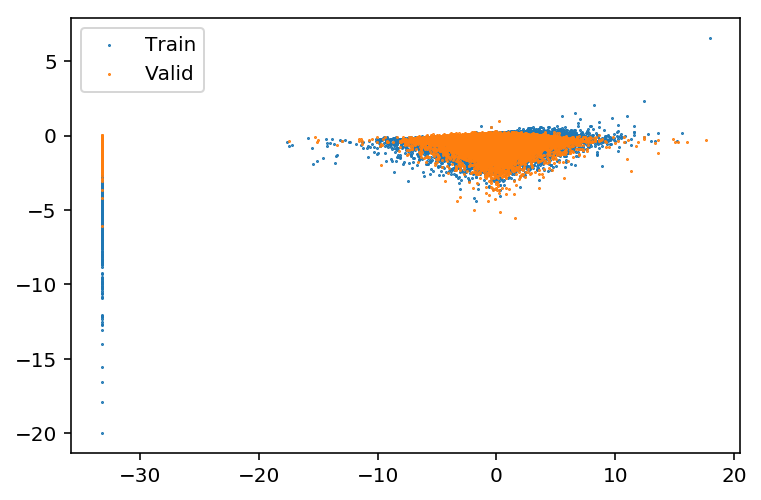

In [13]:
for label, X, y in [("Train", X_train, y_train), ("Valid", X_valid, y_valid)]:
    plt.scatter(y, model.predict(X), s=0.25, label=label)

plt.legend()
plt.show()

In [14]:
%%time

y_test = model.predict(X_test)

CPU times: user 1.59 s, sys: 19.9 ms, total: 1.61 s
Wall time: 467 ms


In [15]:
submission_df = pd.read_csv("data/input/sample_submission.csv")
submission_df.target = y_test
submission_df.head()

,card_id,target
0,C_ID_0ab67a22ab,-1.462944
1,C_ID_130fd0cbdd,-0.674398
2,C_ID_b709037bc5,-0.151572
3,C_ID_d27d835a9f,-0.016200
4,C_ID_2b5e3df5c2,-0.672310


In [16]:
submission_df.isnull().any().any()

False

In [17]:
submission_df.to_csv("submission.csv", index=False)

In [18]:
!head submission.csv

card_id,target
C_ID_0ab67a22ab,-1.462943594081183
C_ID_130fd0cbdd,-0.6743980098344415
C_ID_b709037bc5,-0.15157193560834498
C_ID_d27d835a9f,-0.01619956527502891
C_ID_2b5e3df5c2,-0.672310218942523
C_ID_5814b4f13c,-0.3134729595762985
C_ID_a1b3c75277,-0.02645275687868262
C_ID_f7cada36d3,-0.3616657479431462
C_ID_9d2bc8dfc4,-0.6939886663472449


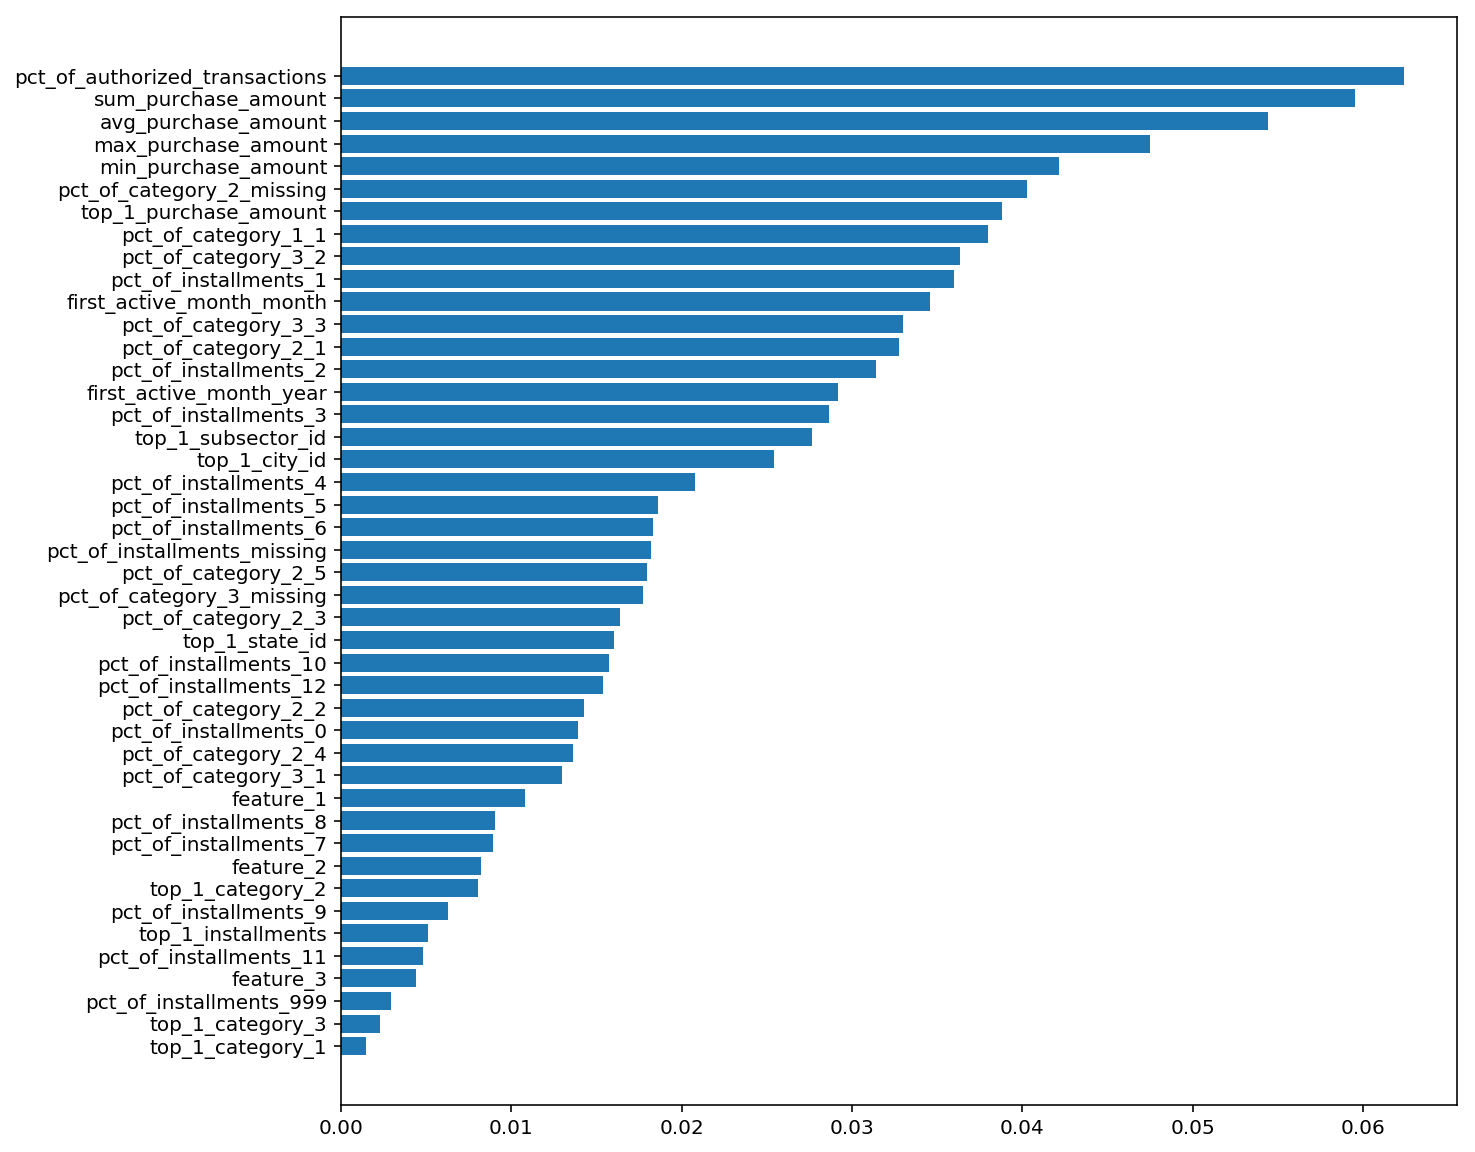

In [19]:
idx = np.argsort(model.feature_importances_)

importances = model.feature_importances_[idx]
columns = X_train.columns.values[idx]

plt.figure(figsize=(10, 10))
plt.barh(columns, importances);